In [6]:
"""
Tiny, modular BoTorch BO for the nanoparticle oracle — CUDA version.

Structure (as requested):
- oracle_noisy(X, sigma): one function that returns *noisy* observations (GPU)
- make_gp(train_x, train_y): one function that builds & fits the GP surrogate (GPU)
- propose_candidates(model, train_x, use_qnehvi=True, q=1): one function for the AF (GPU)
- run_bo(...): loop that alternates GP + AF for a number of iterations
- visualize(...): plot best-so-far (Pareto) and hypervolume
- visual_plus(...): per-iteration surrogate switching (policy-driven)
- visual_plus_compare(...): compare multiple policies (e.g., Random vs Hybrid)

Notes
- We model **maximization** by using Y = 1 - normalize([size, PDI]) in [0,1]^2.
  (So larger is better; ref_point = (0, 0).) Noise is added on the normalized scale.
- qNEHVI is the robust default for noisy observations. qEHVI also provided.
- Replace oracle_noisy(...) with your synthesizer if desired; keep its contract.

Install: pip install botorch gpytorch torch matplotlib
Run on GPU: ensure CUDA is available (torch.cuda.is_available()).
"""

from __future__ import annotations

import torch
from torch import Tensor

from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import SumMarginalLogLikelihood

from botorch.utils.transforms import normalize, unnormalize
from botorch.utils.sampling import draw_sobol_samples
from botorch.optim.optimize import optimize_acqf
from botorch.sampling.normal import SobolQMCNormalSampler

from botorch.acquisition.multi_objective.monte_carlo import (
    qExpectedHypervolumeImprovement,
    qNoisyExpectedHypervolumeImprovement,
)
from botorch.acquisition.multi_objective.logei import qLogNoisyExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume

import matplotlib.pyplot as plt

# ---------------------
# CUDA setup
# ---------------------
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. Please install a CUDA-enabled PyTorch or switch to the CPU version.")

DEVICE = torch.device("cuda")
DTYPE = torch.double

# Make new tensors default to CUDA double unless otherwise specified
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

# ---------------------
# Globals & defaults
# ---------------------
DIM = 4
bounds = torch.zeros(2, DIM, dtype=DTYPE, device=DEVICE)
bounds[1] = 1  # standard [0,1]^4 design space
REF_POINT = torch.tensor([0.0, 0.0], dtype=DTYPE, device=DEVICE)  # maximization

BATCH_Q = 1
NUM_RESTARTS = 10
RAW_SAMPLES = 256
MC_SAMPLES = 128

# --------------------------------------
# 1) Oracle with NOISY output (GPU-only)
# --------------------------------------

def _nanoparticle_oracle_torch(X: Tensor) -> Tensor:
    """Torch oracle on GPU: X (N,4) -> raw Y (N,2) [size, PDI] on DEVICE."""
    x1, x2, x3, x4 = X.unbind(dim=-1)
    y1 = (
        19.36549
        - 0.2797 * x1
        + 1.56885 * x2
        + 3.5447 * x3
        + 1.82225 * x4
        - 1.1978 * x1 * x2
        - 1.66594 * x1 * x3
        - 1.62873 * x1 * x4
        - 0.02003 * x2 * x3
        - 0.001268 * x2 * x4
        - 0.35086 * x3 * x4
        + 0.3914 * (x1 ** 2)
        + 0.52265 * (x2 ** 2)
        - 0.81701 * (x3 ** 2)
        - 2.74921 * (x4 ** 2)
    )
    y2 = (
        19.6114239
        + 1.0313718 * x1
        + 1.48527 * x2
        + 1.7991534 * x3
        - 4.1983899 * x4
        + 1.4263262 * x1 * x2
        - 0.4279443 * x1 * x3
        - 1.3865203 * x1 * x4
        - 1.051601 * x2 * x3
        - 2.06380 * x2 * x4
        - 2.476674 * x3 * x4
        - 0.4497319 * (x1 ** 2)
        - 1.8040123 * (x2 ** 2)
        - 3.8699325 * (x3 ** 2)
        - 2.6148 * (x4 ** 2)
    )
    return torch.stack([y1, y2], dim=-1)

# Pre-compute y-min/y-max for normalization via domain sampling (GPU)
with torch.random.fork_rng(devices=[0]):
    torch.manual_seed(0)
    _Xs = torch.rand(30000, DIM, dtype=DTYPE, device=DEVICE)
    _Ys = _nanoparticle_oracle_torch(_Xs)
Y_MIN = _Ys.min(dim=0).values
Y_MAX = _Ys.max(dim=0).values


def oracle_noisy(X: Tensor, sigma: float = 0.05, seed: int | None = None) -> Tensor:
    """Return **noisy, normalized, maximization** outcomes Y in [0,1]^2 (GPU).

    Contract (keep this if you swap with your synthesizer):
      - Input: X (N, 4) in [0,1]^4 (unnormalized design space)
      - Output: Y (N, 2) where larger is better (i.e., Y = 1 - norm([size, PDI]))
      - Noise: Gaussian N(0, sigma^2) on the normalized scale, clipped to [0,1]
    """
    X = X.to(device=DEVICE, dtype=DTYPE)
    Y_raw = _nanoparticle_oracle_torch(X)  # (N,2) on GPU
    Yn = (Y_raw - Y_MIN) / (Y_MAX - Y_MIN)
    if seed is not None:
        torch.manual_seed(int(seed))
        torch.cuda.manual_seed_all(int(seed))
    Yn = (Yn + sigma * torch.randn_like(Yn))
    Yn = Yn.clamp(0.0, 1.0)
    return 1.0 - Yn  # maximization


# ---------------------------------
# 2) Gaussian Process (single fn)
# ---------------------------------

def make_gp(train_x, train_y, state_dict=None, preset = "m52_ard"):
    from surrogates import Surrogate, PRESETS
    sg = Surrogate(PRESETS[preset])
    Xn = normalize(train_x, bounds)
    if state_dict is not None and sg.model is not None:
        sg.model.load_state_dict(state_dict)
    model, _ = sg.build(Xn, train_y, state_dict=(sg.model.state_dict() if sg.model else None))
    return sg.model, None  # mll is stored in sg.mll


# ---------------------------------
# 3) Acquisition (single fn)
# ---------------------------------

def propose_candidates(
    model,
    train_x: Tensor,
    use_qnehvi: bool = True,
    q: int = BATCH_Q,
):
    """Create the acquisition and return the next q candidates (unnormalized).
    - qNEHVI for noisy observations (default). qEHVI optional.
    - Optimizes over the standard [0,1]^4 bounds. (All CUDA tensors.)
    """
    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    if use_qnehvi:
        acq = qLogNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=REF_POINT,
            X_baseline=normalize(train_x, bounds),
            prune_baseline=True,
            sampler=sampler,
            cache_root=True,
        )
    else:
        with torch.no_grad():
            post_mean = model.posterior(normalize(train_x, bounds)).mean
        part = FastNondominatedPartitioning(ref_point=REF_POINT, Y=post_mean)
        acq = qExpectedHypervolumeImprovement(
            model=model,
            ref_point=REF_POINT,
            partitioning=part,
            sampler=sampler,
        )

    cand, _ = optimize_acqf(
        acq_function=acq,
        bounds=bounds,
        q=q,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    return unnormalize(cand.detach(), bounds=bounds)


# ---------------------------------
# 4) BO loop (single fn)
# ---------------------------------

def run_bo(
    n_init: int = 8,
    n_iter: int = 20,
    sigma: float = 0.05,
    seed: int = 0,
    use_qnehvi: bool = True,
    preset = "m52_ard"
):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Initial design via Sobol on standard bounds (on GPU)
    X_init = draw_sobol_samples(bounds=bounds, n=1, q=n_init, seed=seed).squeeze(0)
    X_init = unnormalize(X_init, bounds=bounds)  # identity here; keeps API clear
    Y_init = oracle_noisy(X_init, sigma=sigma, seed=seed)

    model, mll = make_gp(X_init, Y_init,preset = preset )

    train_x, train_y = X_init, Y_init
    hv_vals = []

    def compute_hv(Y: Tensor):
        mask = is_non_dominated(Y)
        hv = Hypervolume(ref_point=REF_POINT)
        return float(hv.compute(Y[mask]))

    hv_vals.append(compute_hv(train_y))

    for _ in range(n_iter):
        X_new = propose_candidates(model, train_x, use_qnehvi=use_qnehvi, q=BATCH_Q)
        Y_new = oracle_noisy(X_new, sigma=sigma)
        train_x = torch.cat([train_x, X_new])
        train_y = torch.cat([train_y, Y_new])

        state = model.state_dict()
        model, mll = make_gp(train_x, train_y, state_dict=state, preset = preset )
        hv_vals.append(compute_hv(train_y))

    return train_x, train_y, torch.tensor(hv_vals, device=DEVICE, dtype=DTYPE)


# ---------------------------------
# 5) Random policy loop (single fn)
# ---------------------------------

def run_random(
    n_init: int = 8,
    n_iter: int = 20,
    sigma: float = 0.05,
    seed: int = 0,
):
    """Baseline that ignores the model and selects points uniformly at random.
    Returns the same tuple as run_bo: (X, Y, HV).
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Initial random design in [0,1]^4 on GPU
    X_init = torch.rand(n_init, DIM, dtype=DTYPE, device=DEVICE)
    Y_init = oracle_noisy(X_init, sigma=sigma, seed=seed)

    train_x, train_y = X_init, Y_init
    hv_vals = []

    def compute_hv(Y: Tensor):
        mask = is_non_dominated(Y)
        hv = Hypervolume(ref_point=REF_POINT)
        return float(hv.compute(Y[mask]))

    hv_vals.append(compute_hv(train_y))

    for _ in range(n_iter):
        X_new = torch.rand(BATCH_Q, DIM, dtype=DTYPE, device=DEVICE)
        Y_new = oracle_noisy(X_new, sigma=sigma)
        train_x = torch.cat([train_x, X_new])
        train_y = torch.cat([train_y, Y_new])
        hv_vals.append(compute_hv(train_y))

    return train_x, train_y, torch.tensor(hv_vals, device=DEVICE, dtype=DTYPE)


# ---------------------------------
# 6) Multi-run visualize that RUNS methods (requested)
# ---------------------------------

def visualize(*methods,
              n_init: int = 5,
              n_iter: int = 10,
              sigma: float = 0.05,
              seed: int = 123,
              use_qnehvi: bool = True,
              repeats: int = 3):
    """Run one or more runner functions (optionally repeated) and visualize results.

    Each entry in `methods` can be either:
      - a callable like `run_bo` or `run_random` (we'll use defaults), or
      - a tuple (label, callable, kwargs_dict) for custom params per method.

    Returns a dict[label] -> mean HV array (on CPU) and shows mean±std bands.
    """
    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    if len(methods) == 0:
        methods = (
            ("BO-qNEHVI-m32_ard_indep2", run_bo, {"n_init": n_init, "n_iter": n_iter, "sigma": sigma, "seed": seed, "use_qnehvi": use_qnehvi, "preset": "m32_ard_indep2"}),
            ("BO-qNEHVI-m52_indep2",    run_bo, {"n_init": n_init, "n_iter": n_iter, "sigma": sigma, "seed": seed, "use_qnehvi": use_qnehvi, "preset": "m52_indep2"}),
            ("BO-qNEHVI-m52_ard_indep2",run_bo, {"n_init": n_init, "n_iter": n_iter, "sigma": sigma, "seed": seed, "use_qnehvi": use_qnehvi, "preset": "m52_ard_indep2"}),
            ("Random",                  run_random, {"n_init": n_init, "n_iter": n_iter, "sigma": sigma, "seed": seed}),
        )

    # Normalize methods into (label, fn, kwargs)
    norm_methods = []
    auto_seed = seed
    for m in methods:
        if callable(m):
            label = m.__name__
            kwargs = {"n_init": n_init, "n_iter": n_iter, "sigma": sigma, "seed": auto_seed}
            if m is run_bo:
                kwargs["use_qnehvi"] = use_qnehvi
            norm_methods.append((label, m, kwargs))
            auto_seed += 1
        else:
            label, fn, kwargs = m
            if "seed" not in kwargs:
                kwargs = {**kwargs, "seed": auto_seed}
                auto_seed += 1
            norm_methods.append((label, fn, kwargs))

    # Run each method `repeats` times with different seeds; collect results
    results_by_label = {label: [] for (label, _, _) in norm_methods}
    for label, fn, base_kwargs in norm_methods:
        base_seed = int(base_kwargs.get("seed", seed))
        for r in range(repeats):
            kw = dict(base_kwargs)
            kw["seed"] = base_seed + r  # different seed each repeat
            X, Y, HV = fn(**kw)
            results_by_label[label].append((X, Y, HV))

    # Combined Hypervolume plot with mean ± std
    plt.figure()
    hv_curves_mean = {}
    for label, runs in results_by_label.items():
        lengths = [int(run[2].shape[0]) for run in runs]
        T = min(lengths)
        import numpy as np
        hv_stack = np.stack([run[2].detach().cpu().numpy()[:T] for run in runs], axis=0)  # (R, T)
        mean = hv_stack.mean(axis=0)
        std = hv_stack.std(axis=0)

        hv_curves_mean[label] = mean
        x = np.arange(T)
        plt.plot(x, mean, marker="o", label=label)
        plt.fill_between(x, mean - std, mean + std, alpha=0.2)

    plt.xlabel("Iteration"); plt.ylabel("Hypervolume (maximization space)")
    plt.title(f"Hypervolume vs Iteration — comparison (repeats={repeats})")
    plt.legend(); plt.tight_layout()

    # Per-method scatter of observations & Pareto (minimization), fixed axes & aspect
    for label, runs in results_by_label.items():
        Ys = torch.cat([run[1] for run in runs], dim=0)
        Ymin = (1.0 - Ys).clamp(0.0, 1.0)
        nd = is_non_dominated(Ys)
        Y_nd = Ymin[nd]

        Ymin = Ymin.detach().cpu()
        Y_nd = Y_nd.detach().cpu()

        plt.figure()
        plt.scatter(Ymin[:, 0], Ymin[:, 1], alpha=0.35, label=f"{label} obs (all repeats)")
        plt.scatter(Y_nd[:, 0], Y_nd[:, 1], marker="*", s=140, label=f"{label} Pareto (merged)")
        plt.xlim(0.0, 1.0); plt.ylim(0.0, 1.0)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.gca().invert_xaxis(); plt.gca().invert_yaxis()
        plt.xlabel("Size (normalized) ↓"); plt.ylabel("PDI (normalized) ↓")
        plt.title(f"Observations & Pareto — {label} (repeats={repeats})")
        plt.legend(); plt.tight_layout()

    plt.show()
    return hv_curves_mean


# ---------------------------------
# 7) visual_plus: per-iteration surrogate switching (policy-driven)
# ---------------------------------

def random_selector(it, train_x, train_y, presets, **kwargs):
    """Stateless random pick among available presets."""
    import random
    return random.choice(presets)


def hybrid_rule_selector(
    it,
    train_x,
    train_y,
    presets,
    *,
    hv=None,
    n_iter=None,
    state=None,
    stagnation_N: int = 3,
    success_eps: float = 0.0,
    **kwargs,
):
    """Hybrid, phase-based rule selector with stagnation-aware switching.

    Phases by budget fraction f = it / n_iter:
      - Early   (0–30%): prefer ["rbf_iso", "m52_indep2"]
      - Middle  (30–70%): prefer ["m52_ard_indep2"]
      - Late    (70–100%): prefer ["m32_ard_indep2"]

    Rules:
      - If HV improves (> success_eps) from last step, keep current model (if valid
        for the phase), otherwise switch to the phase's primary choice.
      - If HV stagnates for `stagnation_N` consecutive iterations, switch within
        the phase's allowed set (toggle if 2 options, otherwise stay on the sole option).
      - If entering a new phase and current is not in the allowed set, switch immediately
        to the phase primary.

    The `state` dict is mutated in-place to persist across iterations:
      state = {"current": Optional[str], "stagnant": int}
    """
    if state is None:
        state = {}
    current = state.get("current")
    stagnant = int(state.get("stagnant", 0))

    # Determine budget fraction & phase
    f = 0.0 if (n_iter is None or n_iter <= 0) else it / float(n_iter)

    early = ["rbf_iso", "m52_indep2"]
    middle = ["m52_ard_indep2"]
    late = ["m32_ard_indep2"]

    def allowed(cands):
        return [c for c in cands if c in presets]

    if f < 0.30:
        phase_opts = allowed(early) or presets
    elif f < 0.70:
        phase_opts = allowed(middle) or presets
    else:
        phase_opts = allowed(late) or presets

    # Improvement / stagnation
    improving = False
    if isinstance(hv, list) and len(hv) >= 2:
        improving = (hv[-1] - hv[-2]) > success_eps

    # If current invalid for phase, reset to primary
    if current not in phase_opts:
        current = phase_opts[0]
        stagnant = 0
        state["current"], state["stagnant"] = current, stagnant
        return current

    if improving:
        stagnant = 0
        state["current"], state["stagnant"] = current, stagnant
        return current

    # Not improving
    stagnant += 1
    if stagnant >= stagnation_N:
        if len(phase_opts) >= 2:
            current = phase_opts[1] if current == phase_opts[0] else phase_opts[0]
        else:
            current = phase_opts[0]
        stagnant = 0

    state["current"], state["stagnant"] = current, stagnant
    return current


def fixed_model_selector(model_name: str):
    """Factory: returns a selector that always picks `model_name`.
    If `model_name` is not in `presets`, fall back to the first available.
    """
    def _sel(it, train_x, train_y, presets, **kwargs):
        return model_name if model_name in presets else (presets[0] if len(presets) else model_name)
    _sel.__name__ = f"fixed_{model_name}"
    return _sel

    if improving:
        stagnant = 0
        state["current"], state["stagnant"] = current, stagnant
        return current

    # Not improving
    stagnant += 1
    if stagnant >= stagnation_N:
        if len(phase_opts) >= 2:
            current = phase_opts[1] if current == phase_opts[0] else phase_opts[0]
        else:
            current = phase_opts[0]
        stagnant = 0

    state["current"], state["stagnant"] = current, stagnant
    return current


def visual_plus(
    presets=("m52_ard_indep2", "m32_ard_indep2", "rbf_iso", "m52_indep2"),
    selector=random_selector,
    n_init: int = 8,
    n_iter: int = 20,
    sigma: float = 0.05,
    seed: int = 123,
    use_qnehvi: bool = True,
    repeats: int = 3,
    success_eps: float = 0.0,
    eval_sigma: float = 0.0,
    selector_kwargs: dict | None = None,
    plot: bool = True,
):
    """Per-iteration surrogate switching with repeats → mean ± std HV bands + policy accuracy.

    Policy accuracy: At each iteration, simulate **each** surrogate's suggested candidate on the
    current dataset and pick the surrogate with the largest simulated HV gain (using `eval_sigma` noise).
    A success is counted iff the selector's pick equals that simulated-best surrogate.

    Returns
    -------
    (hv_mean_tensor, hv_std_tensor, picks_iter_last, picks_points_last, best_iter_last, policy_acc_mean, policy_acc_std)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from surrogates import Surrogate, PRESETS

    def hv_of(Yt: Tensor) -> float:
        return float(Hypervolume(ref_point=REF_POINT).compute(Yt[is_non_dominated(Yt)]))

    def run_once(seed_local: int):
        torch.manual_seed(seed_local); torch.cuda.manual_seed_all(seed_local)
        X = draw_sobol_samples(bounds=bounds, n=1, q=n_init, seed=seed_local).squeeze(0)
        X = unnormalize(X, bounds=bounds)
        Y = oracle_noisy(X, sigma=sigma, seed=seed_local)
        sgs = {}
        picks_iter, picks_points = [], ["init"] * int(X.shape[0])
        selector_state = {"current": None, "stagnant": 0}
        HV = [hv_of(Y)]
        correct_flags = []
        best_iter = []

        for it in range(n_iter):
            hv_now = HV[-1]
            gains, cands = {}, {}

            # Fit/update ALL candidates on current data & simulate one-step gain
            for name in presets:
                try:
                    if name not in sgs:
                        cfg = PRESETS[name]; cfg.device = DEVICE; cfg.dtype = DTYPE
                        sg = Surrogate(cfg)
                        sg.build(normalize(X, bounds), Y)
                        sgs[name] = sg
                    else:
                        sgs[name].update(normalize(X, bounds), Y)

                    Xp = propose_candidates(sgs[name].model, X, use_qnehvi=use_qnehvi, q=BATCH_Q)
                    Yp = oracle_noisy(Xp, sigma=eval_sigma)
                    gains[name] = hv_of(torch.cat([Y, Yp])) - hv_now
                    cands[name] = (Xp, Yp)
                except Exception:
                    gains[name] = float("-inf")
                    cands[name] = None

            # Best surrogate under simulated gain
            best_name = max(gains, key=gains.get)
            best_iter.append(best_name)

            # Selector chooses the actual surrogate (pass history & state)
            if selector:
                pick = selector(
                    it,
                    X,
                    Y,
                    presets,
                    hv=HV,
                    n_iter=n_iter,
                    state=selector_state,
                    success_eps=success_eps,
                    **(selector_kwargs or {}),
                )
            else:
                pick = presets[0]
            picks_iter.append(pick)

            # Execute chosen surrogate (fallbacks if necessary)
            if cands.get(pick) is None:
                alt = best_name if cands.get(best_name) is not None else None
                if alt is None:
                    X_new = torch.rand(BATCH_Q, DIM, dtype=DTYPE, device=DEVICE)
                    Y_new = oracle_noisy(X_new, sigma=sigma)
                else:
                    X_new, _ = cands[alt]
                    Y_new = oracle_noisy(X_new, sigma=sigma)
            else:
                X_new, _ = cands[pick]
                Y_new = oracle_noisy(X_new, sigma=sigma)

            X = torch.cat([X, X_new]); Y = torch.cat([Y, Y_new])
            picks_points += [pick] * int(X_new.shape[0])
            HV.append(hv_of(Y))

            # Policy classification accuracy (pick equals simulated-best)
            correct_flags.append(1 if (pick == best_name) else 0)

        return X, Y, torch.tensor(HV, device=DEVICE, dtype=DTYPE), picks_iter, picks_points, correct_flags, best_iter

    # ---- Run repeats ----
    runs = [run_once(seed + r) for r in range(repeats)]

    # HV stats
    T = min(int(hv.shape[0]) for (_, _, hv, _, _, _, _) in runs)
    import numpy as np
    hv_stack = np.stack([hv.detach().cpu().numpy()[:T] for (_, _, hv, _, _, _, _) in runs], axis=0)
    hv_mean = hv_stack.mean(axis=0); hv_std = hv_stack.std(axis=0)

    # Policy accuracy across repeats
    accs = [float(np.mean(cf)) for (_, _, _, _, _, cf, _) in runs]
    policy_acc_mean = float(np.mean(accs)) if len(accs) else float('nan')
    policy_acc_std  = float(np.std(accs)) if len(accs) else float('nan')

    # Use last run for qualitative colored plots
    X_last, Y_last, HV_last, picks_iter_last, picks_points_last, _, best_iter_last = runs[-1]

    if plot:
        # ---- Plot HV mean ± std; overlay last run markers colored by surrogate ----
        plt.figure()
        xs = np.arange(T)
        plt.plot(xs, hv_mean, color="black", label="HV mean")
        plt.fill_between(xs, hv_mean - hv_std, hv_mean + hv_std, alpha=0.2, label="±1σ")
        cmap = plt.get_cmap("tab10"); colors = {p: cmap(i % 10) for i, p in enumerate(presets)}
        hv_np_last = HV_last.detach().cpu().numpy()[:T]
        for i in range(1, T):
            name = picks_iter_last[i-1] if (i-1) < len(picks_iter_last) else picks_iter_last[-1]
            plt.scatter(i, hv_np_last[i], color=colors.get(name, "gray"), s=36)
        plt.xlabel("Iteration"); plt.ylabel("Hypervolume (maximization space)")
        plt.title(f"HV vs Iteration — mean±std (repeats={repeats})")
        handles = [plt.Line2D([0],[0], marker='o', linestyle='', color=colors[p], label=p) for p in presets]
        plt.legend(handles=[plt.Line2D([0],[0], color='black', label='mean')] + handles, title="Surrogate", loc='best')
        plt.tight_layout()

        # ---- Policy accuracy bar ----
        plt.figure()
        plt.bar([0], [policy_acc_mean], yerr=[policy_acc_std], alpha=0.6, capsize=4)
        plt.xticks([0], ["Policy accuracy"])
        plt.ylim(0, 1)
        plt.ylabel("Fraction of iterations correct")
        plt.title(f"Selector accuracy (mean ± std over {repeats} repeats)")
        plt.tight_layout()

        # ---- Scatter of last run, points colored by proposing surrogate ----
        Ymin = (1.0 - Y_last).clamp(0.0, 1.0)
        nd = is_non_dominated(Y_last)
        Y_nd = Ymin[nd]
        Ymin_cpu = Ymin.detach().cpu(); Y_nd_cpu = Y_nd.detach().cpu()
        plt.figure()
        for idx in range(Ymin_cpu.shape[0]):
            lab = picks_points_last[idx] if idx < len(picks_points_last) else "init"
            plt.scatter([Ymin_cpu[idx,0]],[Ymin_cpu[idx,1]], alpha=0.5, color=colors.get(lab, "gray"), s=18)
        plt.scatter(Y_nd_cpu[:,0], Y_nd_cpu[:,1], marker='*', s=140, color='k', label='Pareto (last run)')
        plt.xlim(0,1); plt.ylim(0,1); plt.gca().set_aspect('equal', adjustable='box')
        plt.gca().invert_xaxis(); plt.gca().invert_yaxis()
        plt.xlabel("Size (normalized) ↓"); plt.ylabel("PDI (normalized) ↓")
        plt.title("Observations colored by chosen surrogate — last run")
        plt.legend(); plt.tight_layout(); plt.show()

        # Print lists for quick inspection
        try:
            print("Best (simulated) surrogate per iteration:", best_iter_last)
            print("Chosen (selector) surrogate per iteration:", picks_iter_last)
        except Exception:
            pass

    return (
        torch.tensor(hv_mean, device=DEVICE, dtype=DTYPE),
        torch.tensor(hv_std, device=DEVICE, dtype=DTYPE),
        picks_iter_last,
        picks_points_last,
        best_iter_last,
        policy_acc_mean,
        policy_acc_std,
    )


def visual_plus_compare(
    selectors: dict | None = None,
    *,
    presets=("m52_ard_indep2", "m32_ard_indep2", "rbf_iso", "m52_indep2"),
    n_init: int = 3,
    n_iter: int = 20,
    sigma: float = 0.05,
    seed: int = 123,
    use_qnehvi: bool = True,
    repeats: int = 3,
    success_eps: float = 0.0,
    eval_sigma: float = 0.0,
    campaign_model: str | None = "m52_ard_indep2",
):
    """Compare multiple selector policies on the same problem (HV mean±std curves).

    `selectors` maps a display name -> selector function. By default compares
    Random vs Hybrid.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    if selectors is None:
        selectors = {
            "Random": random_selector,
            "Hybrid": hybrid_rule_selector,
        }
        if campaign_model is not None:
            selectors[f"Campaign: {campaign_model}"] = fixed_model_selector(campaign_model)

    curves = {}
    for name, sel in selectors.items():
        hv_mean, hv_std, _, _, _, acc_mean, acc_std = visual_plus(
            presets=presets,
            selector=sel,
            n_init=n_init,
            n_iter=n_iter,
            sigma=sigma,
            seed=seed,
            use_qnehvi=use_qnehvi,
            repeats=repeats,
            success_eps=success_eps,
            eval_sigma=eval_sigma,
            selector_kwargs=None,
            plot=False,
        )
        curves[name] = (hv_mean.detach().cpu().numpy(), hv_std.detach().cpu().numpy(), acc_mean, acc_std)

    # Plot combined HV curves
    plt.figure()
    for name, (m, s, acc_m, acc_s) in curves.items():
        xs = np.arange(len(m))
        plt.plot(xs, m, marker="o", label=f"{name} (acc={acc_m:.2f}±{acc_s:.2f})")
        plt.fill_between(xs, m - s, m + s, alpha=0.2)
    plt.xlabel("Iteration"); plt.ylabel("Hypervolume (maximization space)")
    plt.title(f"Policy comparison (repeats={repeats})")
    plt.legend(); plt.tight_layout(); plt.show()

# Example usage:
# hvm, hvs, picks, tags, best, acc_m, acc_s = visual_plus(selector=hybrid_rule_selector, repeats=3, seed=2355632)
# visual_plus_compare(repeats=20, seed=765)







/home/amirreza/anaconda3/envs/pol_env/lib/python3.11/site-packages/torch/__init__.py:1264: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [1]:
# ==== Exhaustive short-sequence benchmarking (fixed seed) ====
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import torch

@torch.no_grad()
def _hv_of(Y: torch.Tensor) -> float:
    mask = is_non_dominated(Y)
    return float(Hypervolume(ref_point=REF_POINT).compute(Y[mask]))

def run_sequence(seq, *, n_init=8, sigma=0.05, seed=0, use_qnehvi=True):
    """
    Run a deterministic campaign that follows `seq` of surrogate names,
    one per BO iteration (length L = len(seq)).
    Returns X, Y, HV (length L+1 with initial HV).
    """
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    # Initial design
    X = draw_sobol_samples(bounds=bounds, n=1, q=n_init, seed=seed).squeeze(0)
    X = unnormalize(X, bounds=bounds)
    Y = oracle_noisy(X, sigma=sigma, seed=seed)
    HV = [_hv_of(Y)]

    # Cache surrogates; each is (re)fit on the accumulating data when used
    from surrogates import Surrogate, PRESETS
    sg_cache = {}

    for name in seq:
        
        if name not in PRESETS:
            raise KeyError(f"Unknown preset: {name}")
        if name not in sg_cache:
            cfg = PRESETS[name]; cfg.device = DEVICE; cfg.dtype = DTYPE
            sg = Surrogate(cfg)
            sg.build(normalize(X, bounds), Y)
            sg_cache[name] = sg
        else:
            sg_cache[name].update(normalize(X, bounds), Y, warm_start=True)
        model = sg_cache[name].model
        X_new = propose_candidates(model, X, use_qnehvi=use_qnehvi, q=BATCH_Q)


        Y_new = oracle_noisy(X_new, sigma=sigma)
        X = torch.cat([X, X_new], dim=0)
        Y = torch.cat([Y, Y_new], dim=0)
        HV.append(_hv_of(Y))

    return X, Y, torch.tensor(HV, device=DEVICE, dtype=DTYPE)

def grid_search_sequences(
    *,
    models=("m52_ard_indep2", "m32_ard_indep2", "rbf_iso", "m52_indep2", "m52_ard"),
    L=3,
    n_init=8,
    sigma=0.05,
    seed=123,
    use_qnehvi=True,
    metric="final",       # 'final' | 'auc' | 'lexi'
    top_k=10,
    plot_top=5,
):
    """
    Enumerate all `len(models)**L` sequences at fixed seed and rank them.
    metric:
      - 'final' : maximize HV at last step (tie-breaker AUC)
      - 'auc'   : maximize sum of HV across steps (tie-breaker final)
      - 'lexi'  : lexicographic max of (HV_1, HV_2, ..., HV_L)
    Returns (best_list, all_results)
      where each item has {'seq','HV','final','auc'}
    """
    # Filter to available presets
    from surrogates import PRESETS
    models = tuple([m for m in models if m in PRESETS])
    assert len(models) >= 1, "No valid models provided."

    results = []
    for seq in product(models, repeat=L):
        _, _, HV = run_sequence(seq, n_init=n_init, sigma=sigma, seed=seed, use_qnehvi=use_qnehvi)
        hv = HV.detach().cpu().numpy()
        # Ignore HV[0] for lexicographic ranking (that one is shared across all sequences)
        lexi_key = tuple(-hv[1:])  # negative for descending sort
        results.append({
            "seq": seq,
            "HV": hv,
            "final": hv[-1],
            "auc": hv.sum(),
            "lexi_key": lexi_key,
        })

    if metric == "final":
        results.sort(key=lambda r: (r["final"], r["auc"]), reverse=True)
    elif metric == "auc":
        results.sort(key=lambda r: (r["auc"], r["final"]), reverse=True)
    elif metric == "lexi":
        # smallest lexi_key corresponds to largest hv[1:], thanks to negative sign
        results.sort(key=lambda r: r["lexi_key"])
    else:
        raise ValueError("metric must be one of: 'final', 'auc', 'lexi'.")

    best = results[:top_k]

    # Optional plot of top trajectories
    if plot_top and plot_top > 0:
        plt.figure()
        for r in best[:plot_top]:
            xs = np.arange(len(r["HV"]))
            label = "→".join(r["seq"]) + f" (final {r['final']:.3f})"
            plt.plot(xs, r["HV"], marker="o", label=label)
        plt.xlabel("Iteration")
        plt.ylabel("Hypervolume (maximization space)")
        plt.title(f"Top {min(plot_top, len(best))} sequences — metric={metric}, L={L}, seed={seed}")
        plt.legend(fontsize=8)
        plt.tight_layout()
        plt.show()

    return best, results


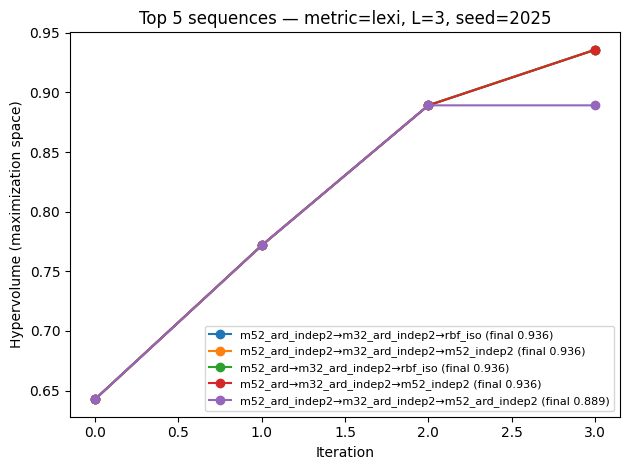

 1. ('m52_ard_indep2', 'm32_ard_indep2', 'rbf_iso')  final=0.9358  AUC=3.2394
 2. ('m52_ard_indep2', 'm32_ard_indep2', 'm52_indep2')  final=0.9358  AUC=3.2394
 3. ('m52_ard', 'm32_ard_indep2', 'rbf_iso')  final=0.9358  AUC=3.2394
 4. ('m52_ard', 'm32_ard_indep2', 'm52_indep2')  final=0.9358  AUC=3.2394
 5. ('m52_ard_indep2', 'm32_ard_indep2', 'm52_ard_indep2')  final=0.8892  AUC=3.1928


In [3]:
# 5 models, 3-step sequences -> 125 scenarios
best, allres = grid_search_sequences(
    models=("m52_ard_indep2", "m32_ard_indep2", "rbf_iso", "m52_indep2", "m52_ard"),
    L=3,
    n_init=5,
    sigma=0.05,
    seed=2025,
    metric="lexi",   # or 'final' or 'auc'
    top_k=10,
    plot_top=5,
)

# Print the top-5 sequences and their final HV
for i, r in enumerate(best[:5], 1):
    print(f"{i:>2}. {r['seq']}  final={r['final']:.4f}  AUC={r['auc']:.4f}")


In [11]:
# ============================
# Sequence mining for LSTM data
# ============================
import torch, numpy as np, json, os, traceback
from typing import List, Tuple, Dict, Any

# Global sink (append-only) – survives errors inside the loop
MINED_DATASET: List[Dict[str, Any]] = []

@torch.no_grad()
def _hv_of(Y: torch.Tensor) -> float:
    mask = is_non_dominated(Y)
    return float(Hypervolume(ref_point=REF_POINT).compute(Y[mask]))

def _sample_sequence(
    models: Tuple[str, ...],
    L: int,
    sampler: str = "iid_uniform",
    rng: np.random.Generator | None = None,
    dirichlet_alpha: float = 1.0,
) -> Tuple[str, ...]:
    """Return a random sequence of length L from `models`."""
    rng = rng or np.random.default_rng()
    if sampler == "iid_uniform":
        idx = rng.integers(0, len(models), size=L)
        return tuple(models[i] for i in idx)
    elif sampler == "dirichlet_per_sequence":
        # Draw per-sequence category probabilities, then sample each position
        p = rng.dirichlet([dirichlet_alpha] * len(models))
        idx = rng.choice(len(models), size=L, p=p)
        return tuple(models[i] for i in idx)
    elif sampler == "phase_bias":
        # Example: explore→balance→exploit phases in thirds
        thirds = [int(np.ceil(L/3)), int(np.floor(L/3)), L - int(np.ceil(L/3)) - int(np.floor(L/3))]
        early, mid, late = thirds
        early_set  = [m for m in ("rbf_iso", "m52_indep2") if m in models] or list(models)
        middle_set = [m for m in ("m52_ard_indep2",) if m in models] or list(models)
        late_set   = [m for m in ("m32_ard_indep2",) if m in models] or list(models)
        seq = []
        seq += list(rng.choice(early_set,  size=early))
        seq += list(rng.choice(middle_set, size=mid))
        seq += list(rng.choice(late_set,   size=late))
        return tuple(seq)
    else:
        raise ValueError("sampler must be one of: iid_uniform | dirichlet_per_sequence | phase_bias")

def mine_sequences_dataset(
    *,
    n_iter: int = 20,                # sequence length
    n_samples: int = 500,            # how many sequences to generate
    n_init: int = 3,
    sigma: float = 0.05,
    seed: int = 12345,
    use_qnehvi: bool = True,
    models: Tuple[str, ...] = ("m52_ard_indep2","m32_ard_indep2","rbf_iso","m52_indep2","m52_ard"),
    sampler: str = "iid_uniform",    # or 'dirichlet_per_sequence' / 'phase_bias'
    dirichlet_alpha: float = 1.0,
    save_path: str | None = "mined_sequences.pt",   # set None to disable
    save_every: int = 10,
    log_every: int = 10,
    strict_presets: bool = True,     # drop unknown model names when True
    max_retries_per_step: int = 1,   # retries if acq optimization fails; then fallback to random
) -> List[Dict[str, Any]]:
    """
    Generate `n_samples` sequences of length `n_iter` using random/fair sampling.
    For each sequence, run a BO campaign that *follows* that surrogate order.

    Returns MINED_DATASET (also autosaved every `save_every` sequences if save_path is set).

    Each entry in MINED_DATASET:
      {
        'seed': int,
        'seq': [str, ...],                 # chosen surrogate names (length n_iter)
        'models': [str, ...],              # model universe used
        'n_init': int,
        'sigma': float,
        'use_qnehvi': bool,
        'X_full': np.ndarray [n_init+n_iter, DIM],
        'Y_full': np.ndarray [n_init+n_iter, 2],
        'HV': np.ndarray [n_iter+1],       # includes HV after init
        'X_iter': [np.ndarray (1,DIM),...],# per-iteration new X (q=1)
        'Y_iter': [np.ndarray (1,2),...],  # per-iteration new Y
        'error': Optional[str],            # present if a fatal error occurred
      }
    """
    from surrogates import Surrogate, PRESETS

    # Filter models to available presets
    if strict_presets:
        models = tuple([m for m in models if m in PRESETS])
        if len(models) == 0:
            raise ValueError("No valid models after filtering against PRESETS.")

    rng = np.random.default_rng(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

    for k in range(n_samples):
        seq = _sample_sequence(models=models, L=n_iter, sampler=sampler, rng=rng, dirichlet_alpha=dirichlet_alpha)
        run_seed = seed + k  # different campaign seed per sample

        try:
            # Initialize
            torch.manual_seed(run_seed); torch.cuda.manual_seed_all(run_seed)
            X = draw_sobol_samples(bounds=bounds, n=1, q=n_init, seed=run_seed).squeeze(0)
            X = unnormalize(X, bounds=bounds)
            Y = oracle_noisy(X, sigma=sigma, seed=run_seed)
            HV = [_hv_of(Y)]

            # Cache built surrogates by name (re-fit/update on current data when used)
            sg_cache: Dict[str, Surrogate] = {}
            X_iters, Y_iters = [], []

            # Rollout the sequence
            for t, name in enumerate(seq):
                # Build/update model
                attempt = 0
                while True:
                    try:
                        if (name not in sg_cache):
                            cfg = PRESETS[name]; cfg.device = DEVICE; cfg.dtype = DTYPE
                            sg = Surrogate(cfg)
                            sg.build(normalize(X, bounds), Y)
                            sg_cache[name] = sg
                        else:
                            sg_cache[name].update(normalize(X, bounds), Y, warm_start=True)
                        model = sg_cache[name].model

                        # Propose and observe
                        X_new = propose_candidates(model, X, use_qnehvi=use_qnehvi, q=1)
                        Y_new = oracle_noisy(X_new, sigma=sigma)
                        break
                    except Exception:
                        print("exception has been seen")
                        attempt += 1
                        if attempt > max_retries_per_step:
                            # fallback to random step to keep dataset growing
                            X_new = torch.rand(1, DIM, device=DEVICE, dtype=DTYPE)
                            Y_new = oracle_noisy(X_new, sigma=sigma)
                            break
                        # else retry once (e.g., transient optimizer failure)

                X = torch.cat([X, X_new], dim=0)
                Y = torch.cat([Y, Y_new], dim=0)
                X_iters.append(X_new.detach().cpu().numpy())
                Y_iters.append(Y_new.detach().cpu().numpy())
                HV.append(_hv_of(Y))

            entry = {
                "seed": run_seed,
                "seq": list(seq),
                "models": list(models),
                "n_init": int(n_init),
                "sigma": float(sigma),
                "use_qnehvi": bool(use_qnehvi),
                "X_full": X.detach().cpu().numpy(),
                "Y_full": Y.detach().cpu().numpy(),
                "HV": np.asarray(HV, dtype=float),
                "X_iter": X_iters,
                "Y_iter": Y_iters,
            }
            MINED_DATASET.append(entry)

        except Exception as e:
            print("exception has been seen")
            # Record partial progress with an error message; continue mining
            entry = {
                "seed": run_seed,
                "seq": list(seq),
                "models": list(models),
                "n_init": int(n_init),
                "sigma": float(sigma),
                "use_qnehvi": bool(use_qnehvi),
                "error": f"{type(e).__name__}: {str(e)}",
                "traceback": traceback.format_exc(limit=1),
            }
            MINED_DATASET.append(entry)

        # Autosave & log
        if save_path and ((k + 1) % save_every == 0):
            try:
                torch.save(MINED_DATASET, save_path)  # robust pickle
            except Exception:
                # Fallback to simple npz: strip tensors to arrays
                safe = [{
                    **{k: v for k, v in d.items() if k not in ("traceback",)},
                    "X_full": d.get("X_full", None),
                    "Y_full": d.get("Y_full", None),
                    "HV": d.get("HV", None),
                    "X_iter": d.get("X_iter", None),
                    "Y_iter": d.get("Y_iter", None),
                } for d in MINED_DATASET]
                np.savez_compressed(os.path.splitext(save_path)[0] + ".npz", data=safe, allow_pickle=True)

        if (k + 1) % log_every == 0:
            print(f"[mine_sequences_dataset] Collected {k+1}/{n_samples} sequences.")

    # Final save
    if save_path:
        try:
            torch.save(MINED_DATASET, save_path)
        except Exception:
            np.savez_compressed(os.path.splitext(save_path)[0] + ".npz", data=MINED_DATASET, allow_pickle=True)

    return MINED_DATASET


In [ ]:
import warnings
warnings.filterwarnings("ignore") 
# Mine 2,000 sequences of length 20 with iid-uniform sampling
dataset = mine_sequences_dataset(
    n_iter=20,
    n_samples=10000,
    n_init=3,
    sigma=0.05,
    seed=777,
    sampler="iid_uniform",              # or "dirichlet_per_sequence" / "phase_bias"
    save_path="mined_sequences.pt",     # autosaves every 10 runs
    save_every=50,
    log_every=50,
)

In [19]:
loaded = torch.load("mined_sequences.pt", map_location="cuda", weights_only=False)
